#Procesamiento de datos del Visound
Esta rutina procesa y visualiza los datos que se generan con el programa visound.
La app va subiendo los datos a un servidor. Este servidor corre en una virtual machine en la compu de casa sobre un ubuntu server en el que instale un json-server. 
Esta rutina descarga los datos del servidor en su ultima version y los procesa para hacer una visualizacion de la actividad de los usuarios en forma grafica (un timeline de la actividad)

In [1]:
%matplotlib inline
from IPython import embed
from IPython.display import display
from graficos import *
from load import *
from DownloadFile import *

# Recoleccion de datos

Bajamos la ultima version del archivo de internet y nos fijamos de guardar la version anterior con una marca temporal

In [5]:
DownloadFile ()

Starting download, please wait
Donload finish


In [2]:
touchs, sounds = load(5)

recursos cargados del archivo


In [4]:
sounds.columns

Index(['trialInstance', 'soundSourceId', 'soundInstance',
       'categoriasElementos', 'categoriasRta', 'idRtaCorrecta',
       'jsonMetaDataRta', 'jsonTrial', 'levelInstance', 'resourcesIdSort',
       'resourcesVersion', 'timeTrialExit', 'timeTrialStart', 'tipoDeTrial',
       'trialCompleted', 'trialId', 'trialTitle', 'userName', 'version',
       'levelCompleted', 'levelId', 'levelTitle', 'sessionInstance',
       'timeLevelExit', 'timeLevelStarts', 'codeVersion', 'userID', 'Alias'],
      dtype='object')

# Con los datos ya cargados graficamos los resultados

La idea de esta seccion es hacer un analisis visual de los datos. Para eso vamos a armar un timeline donde vamos a mostrar con dibujos (lines, rectangulos, etc) lo que va pasando en el juego en funcion de diferentes criterios. Para un usuario cuando jugo, en usa sesion que paso, etc.

/home/ionatan/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


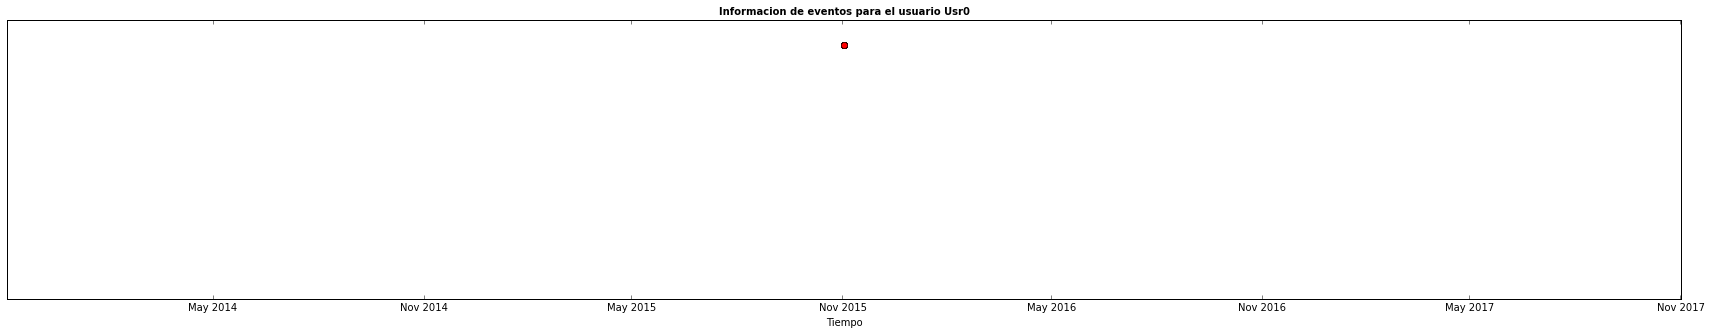

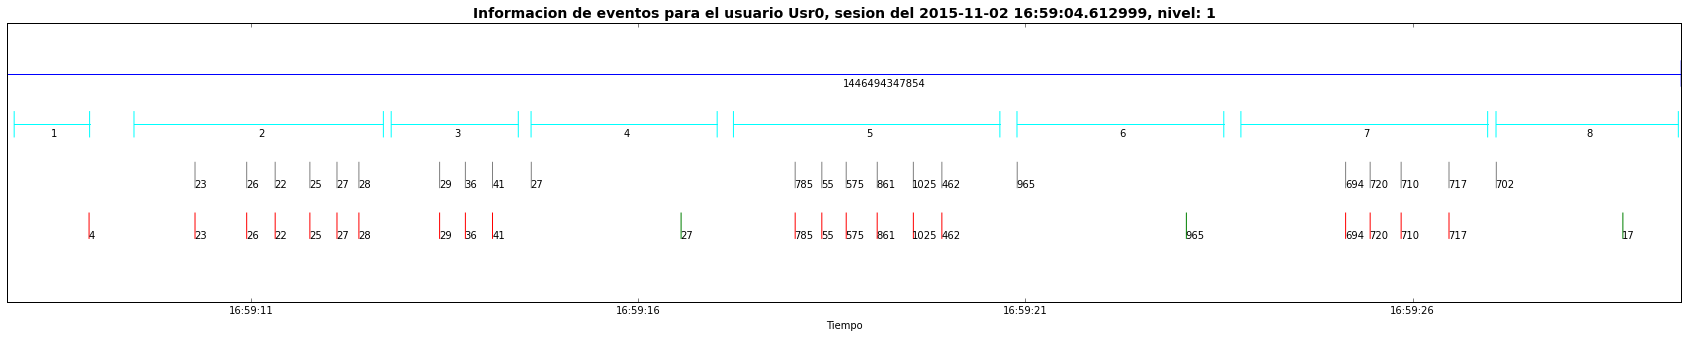

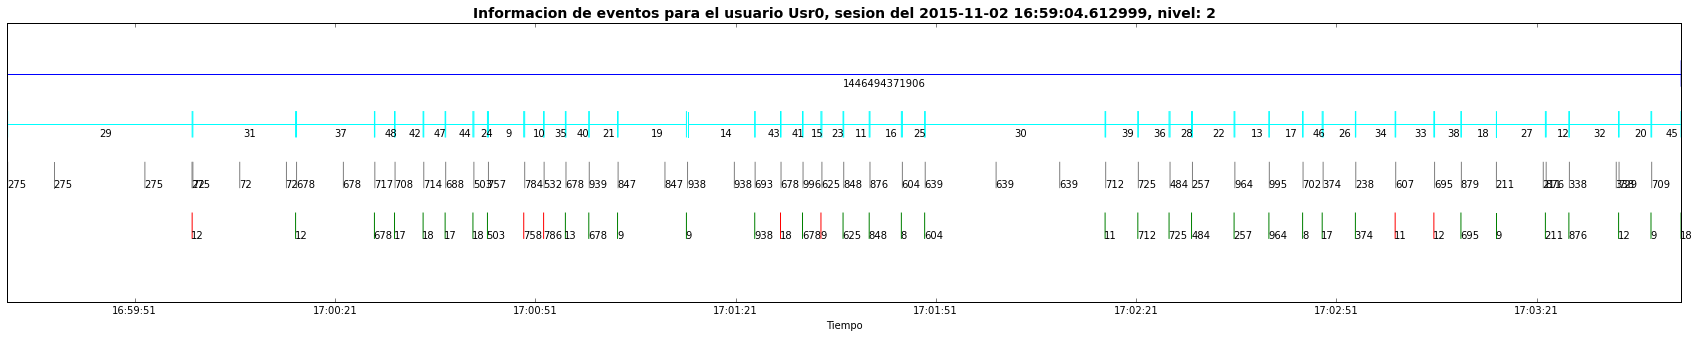

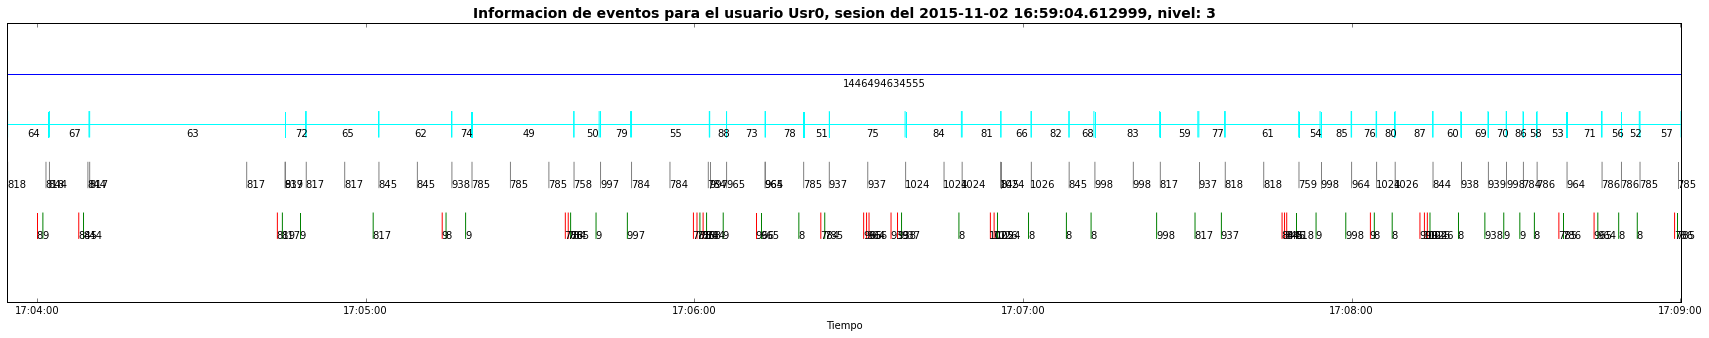

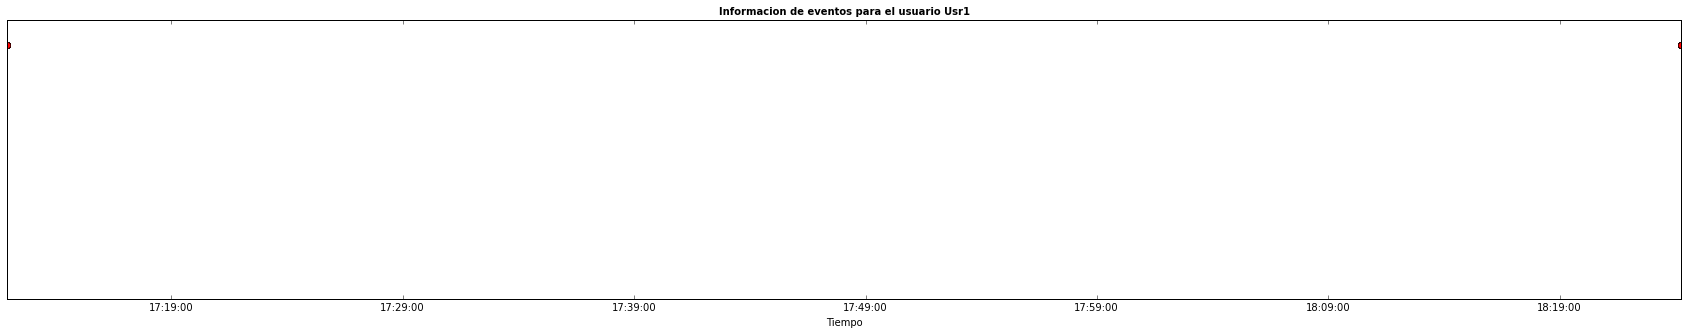

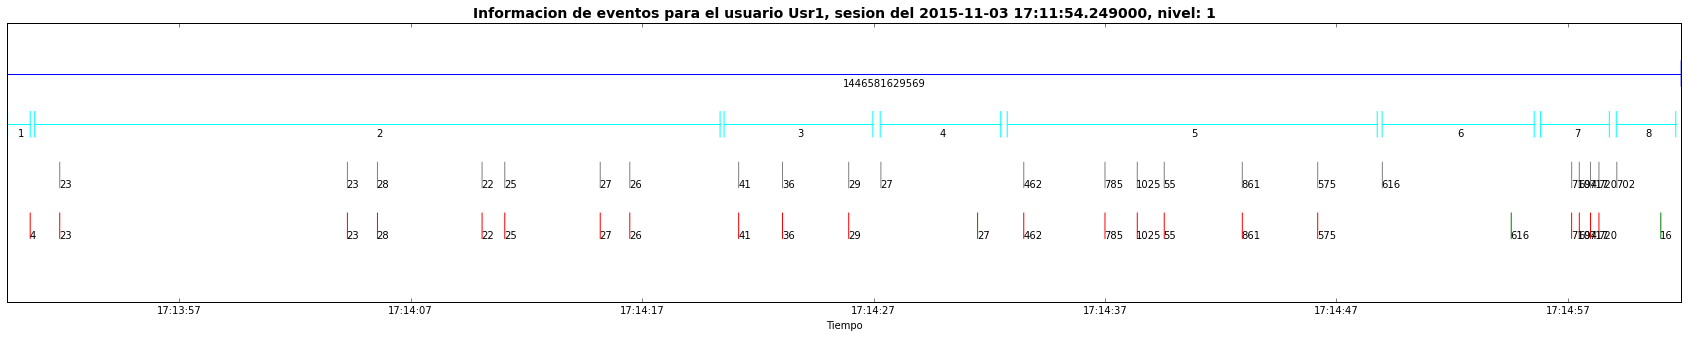

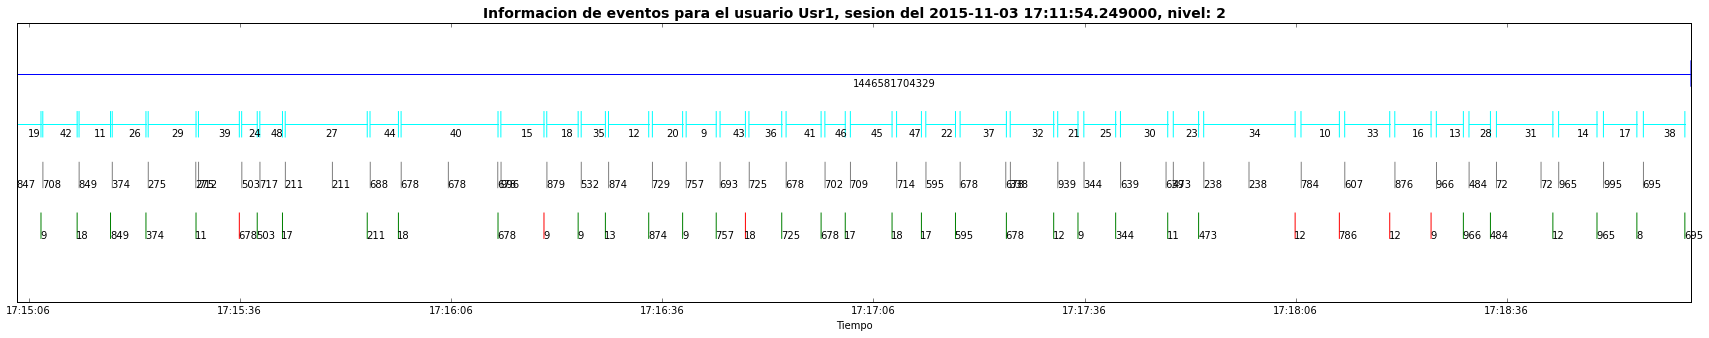

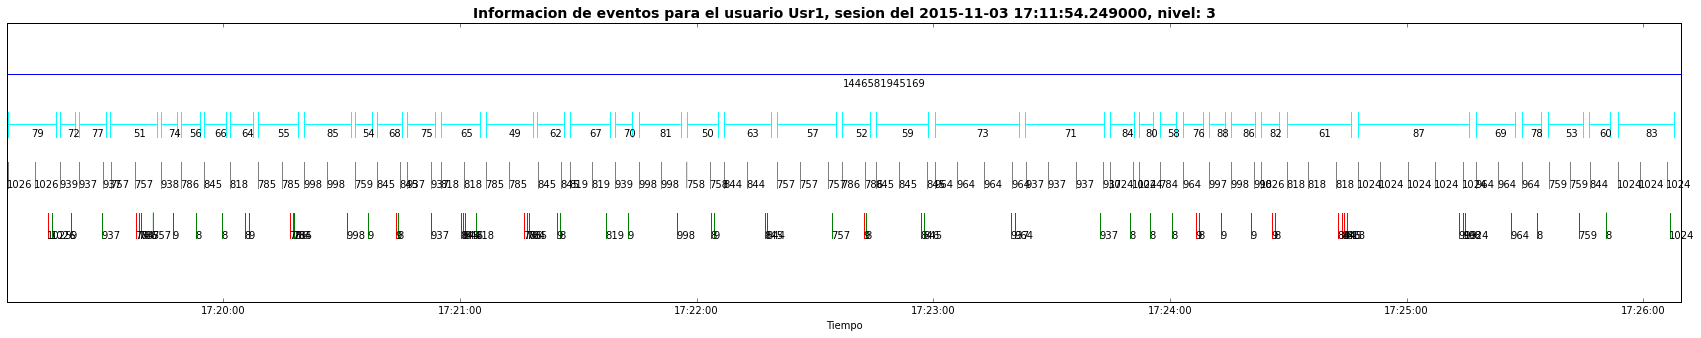

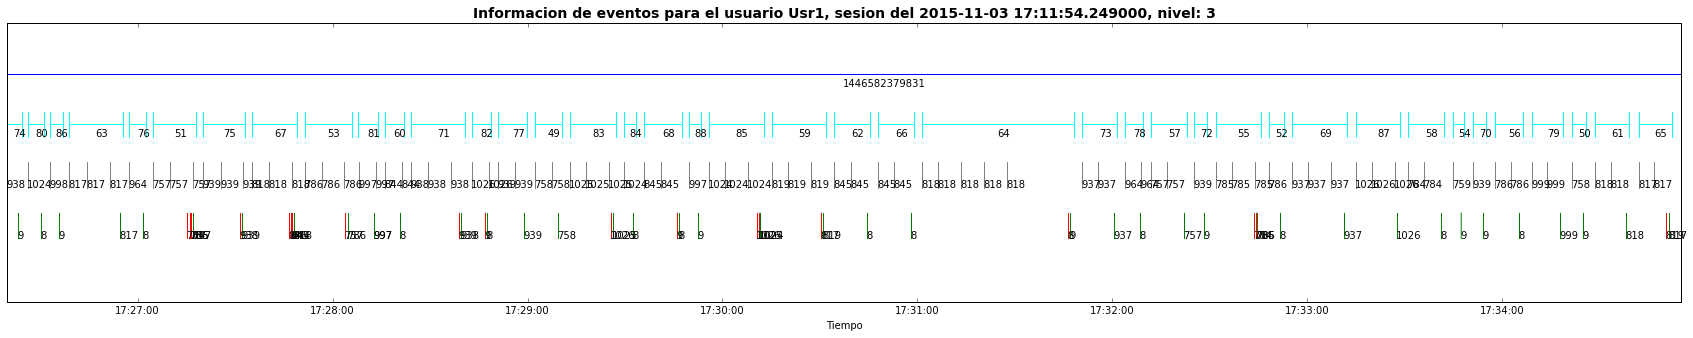

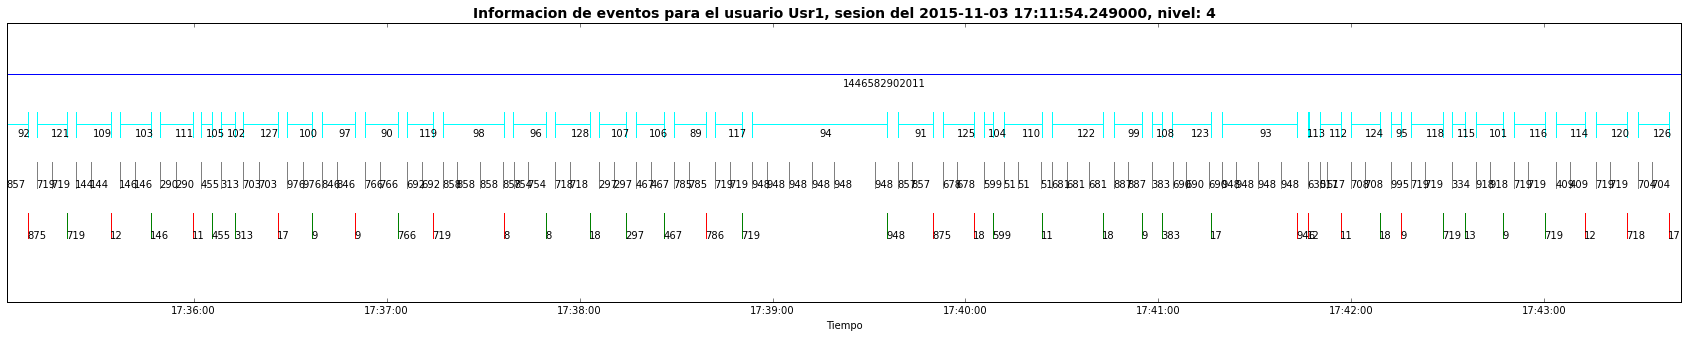

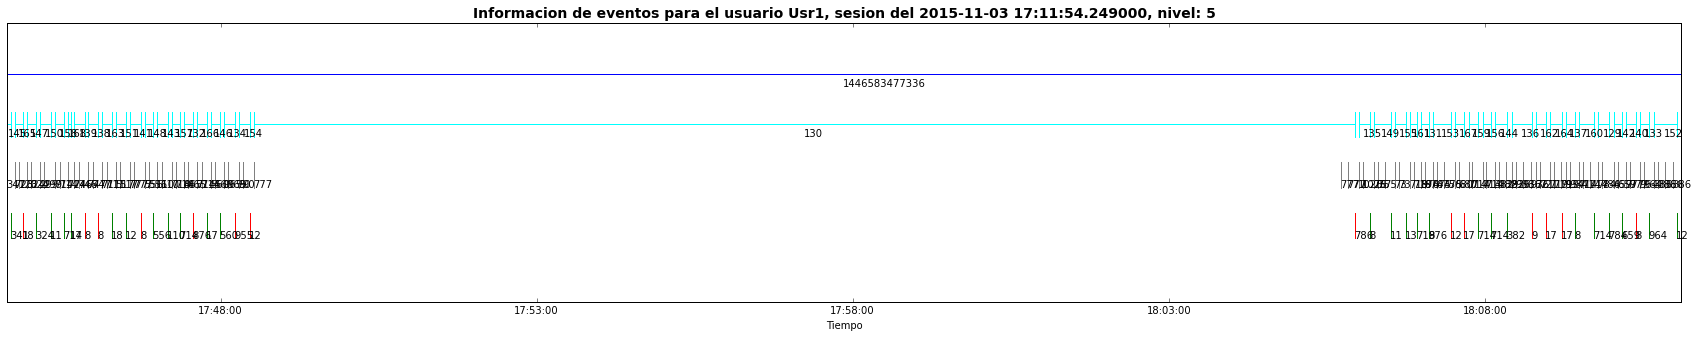

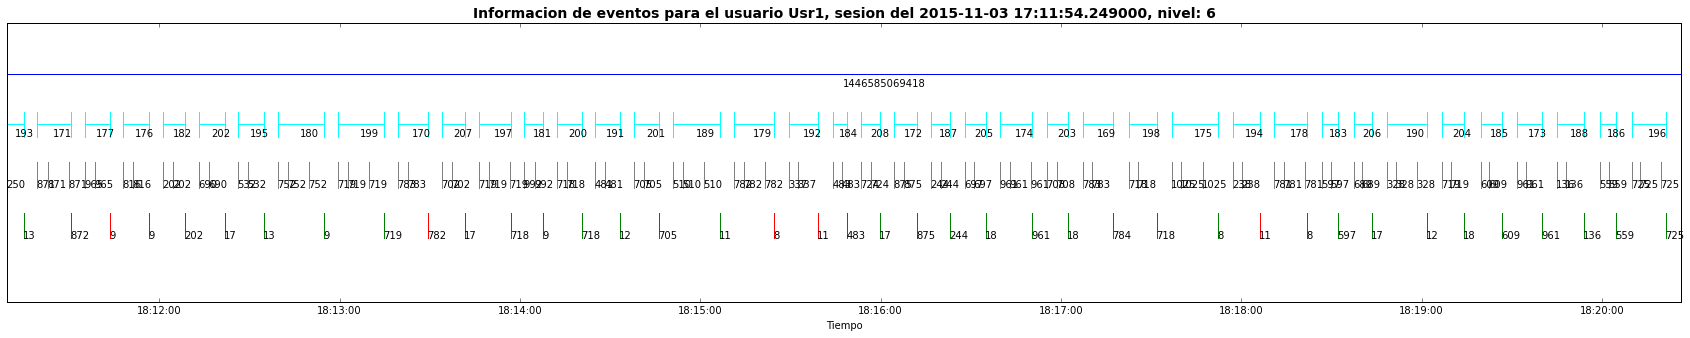

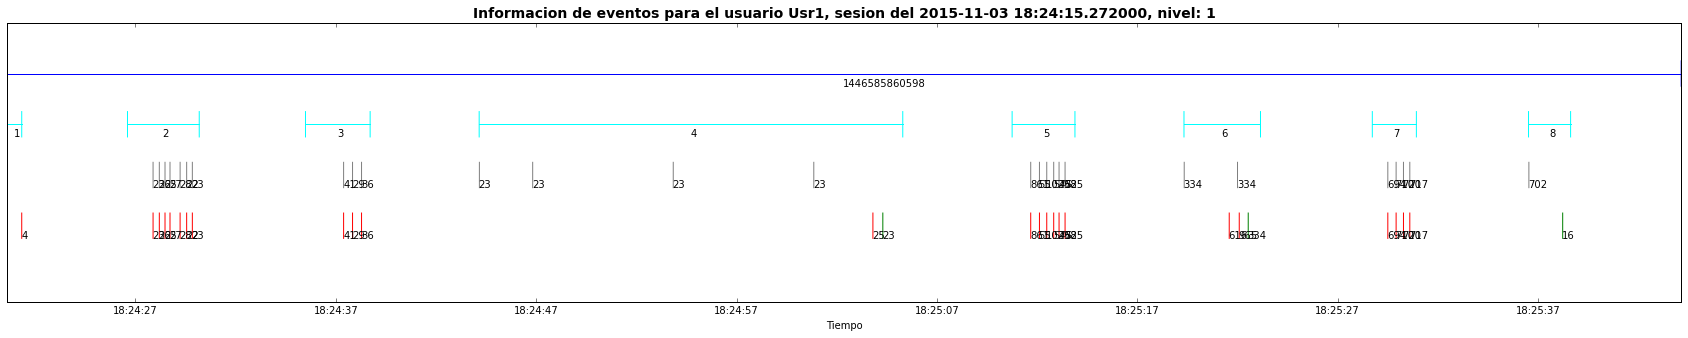

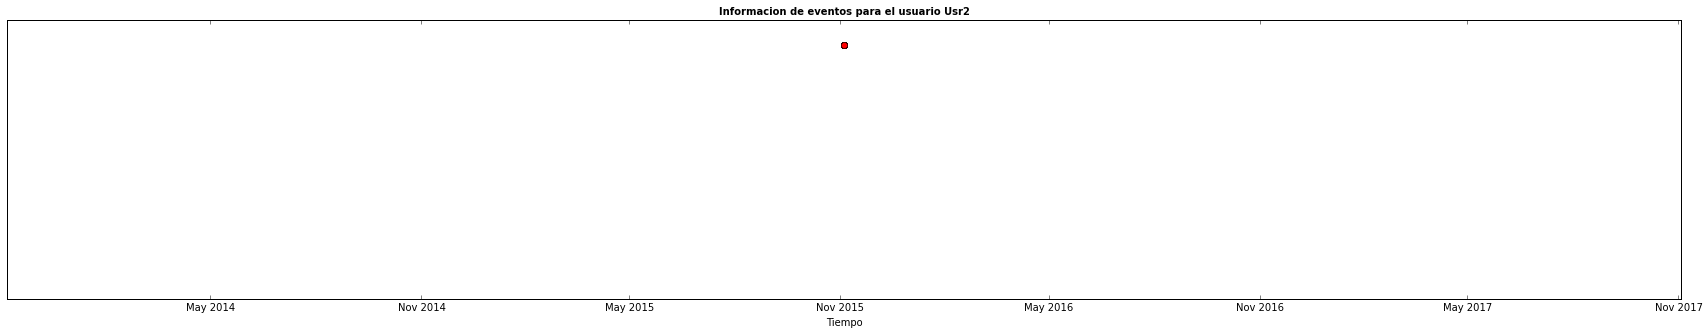

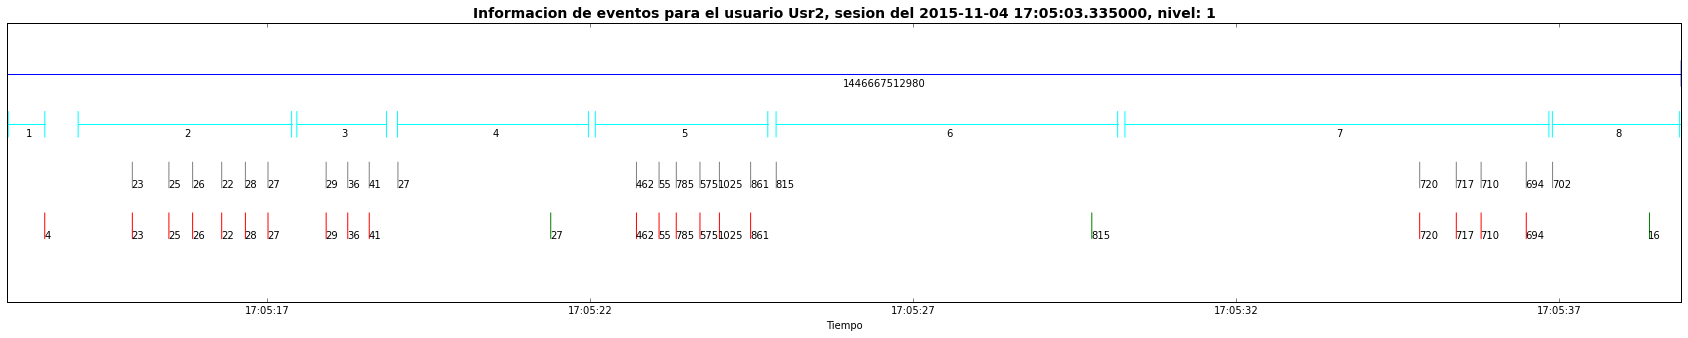

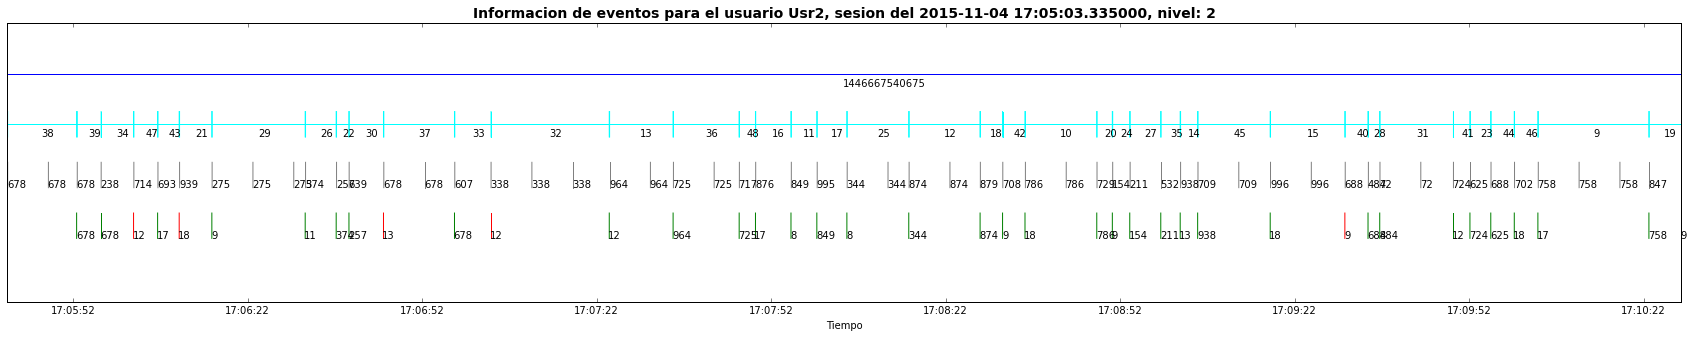

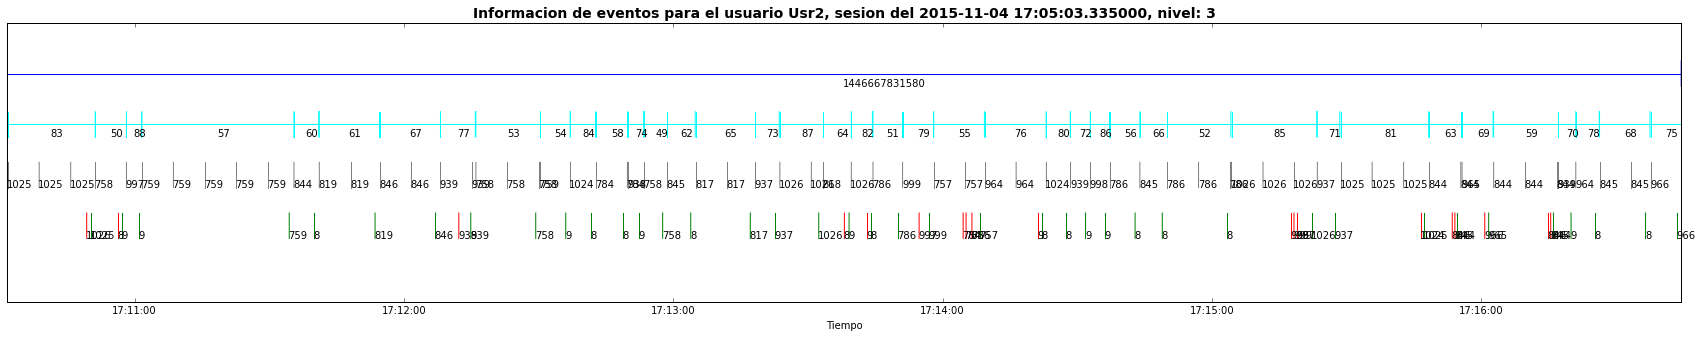

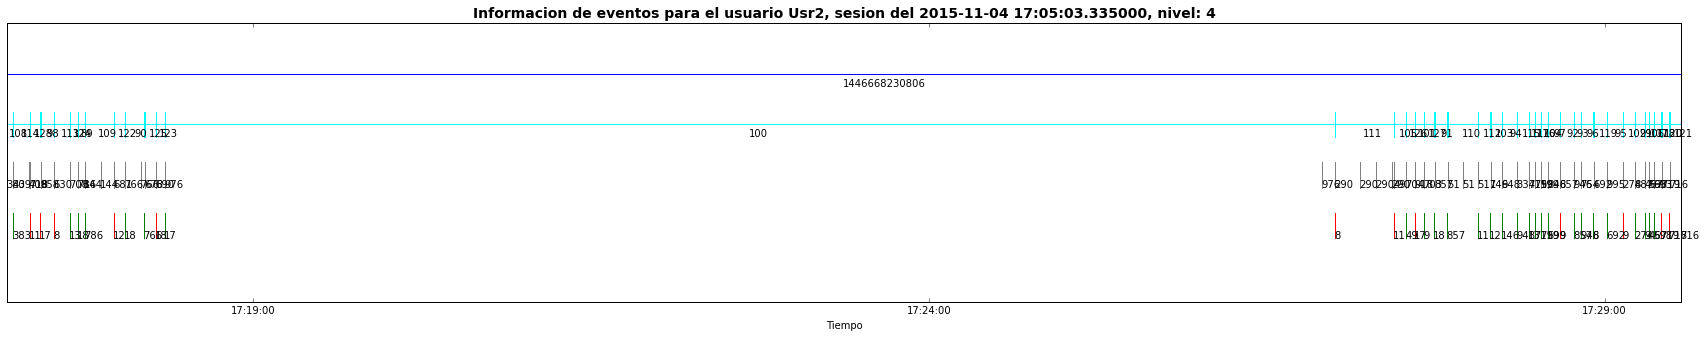

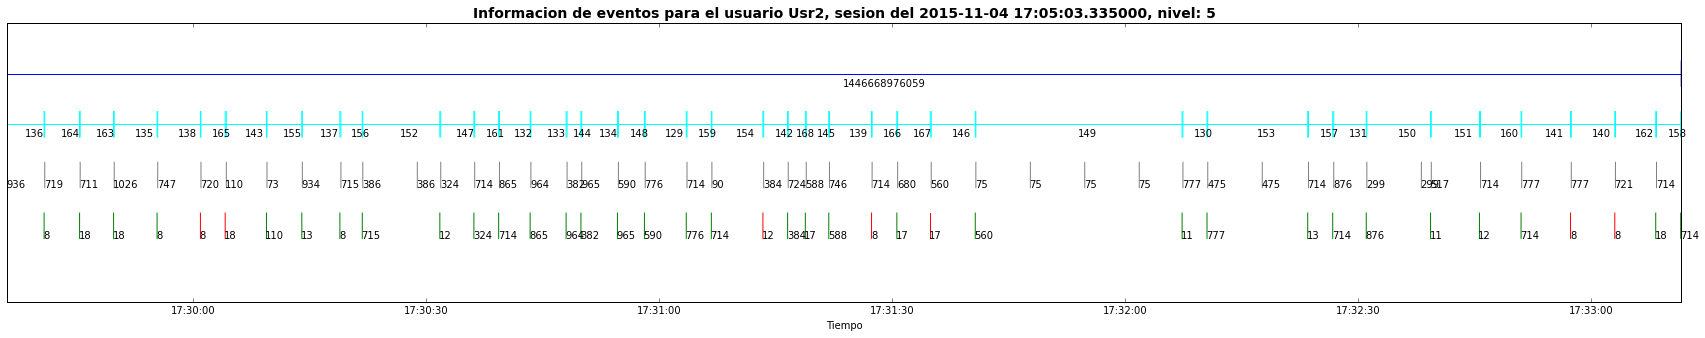

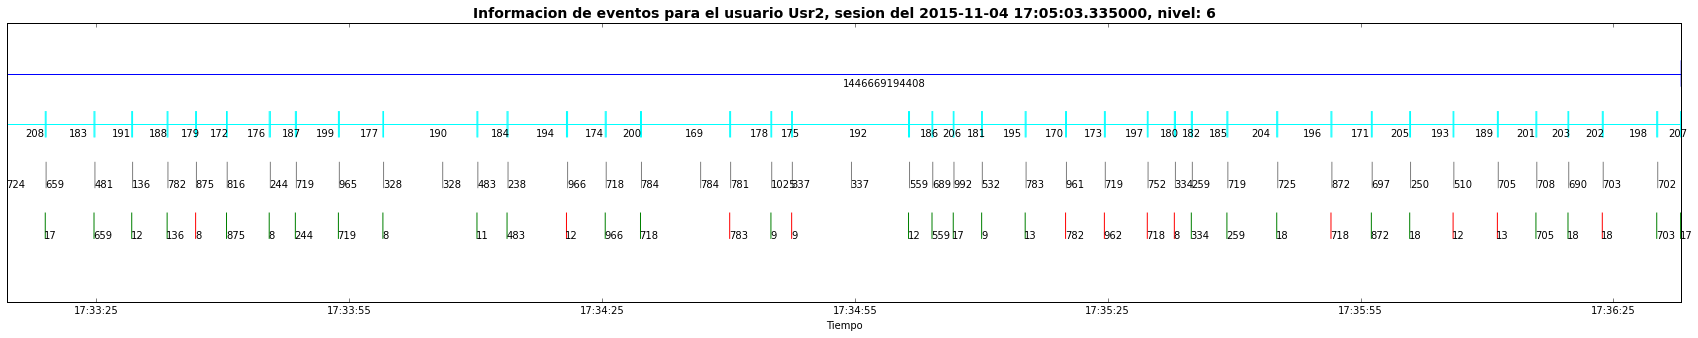

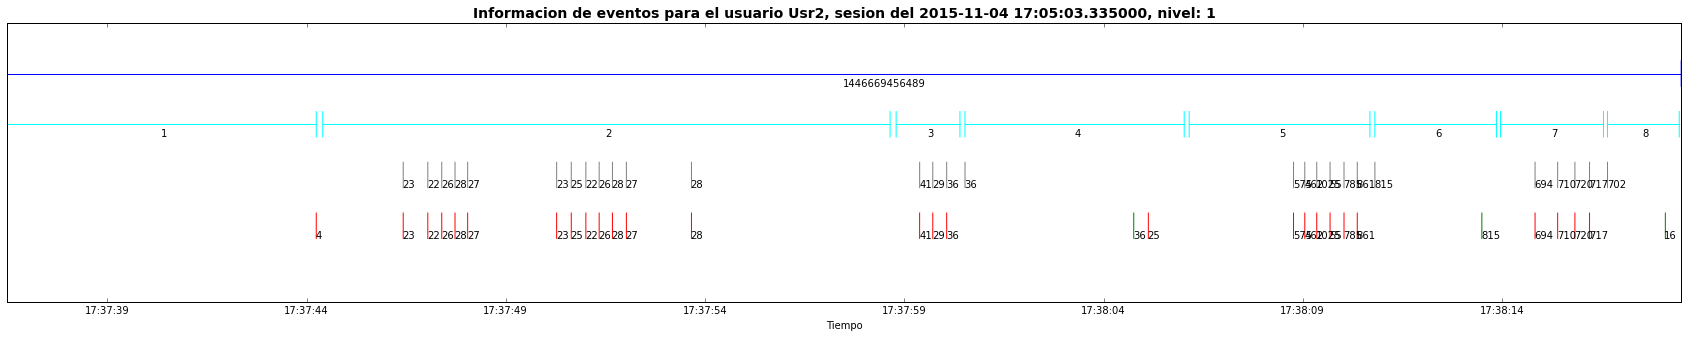

In [7]:
makeTimeline (touchs, sounds)

# Cosas de estadistica

En esta seccion se va a hacer un procesamiento estidistico de los datos para evaluar los resultados en funcion de diferentes parametros.


In [6]:
from Scripts import fechaLocal
from Scripts import makeHistogramaTrials
from Scripts import distribucionDeProbabilidadRandom
from Scripts import findTrueFirstTouch
from Scripts import significativos

import matplotlib.pyplot as plt
import pandas as pd


showPlots = False
reporteSimplificado = True
reporteSignificancia = []

for usuario in touchs['Alias'].unique():
    display ('Se hara la estadistica del usuario: '+usuario)
    touchsUsuario = touchs[touchs['Alias']==usuario]
    display ('El usuario '+usuario+' jugo '+str(len(touchsUsuario['sessionInstance'].unique()))+' veces')
    for session in touchsUsuario['sessionInstance'].unique():
        touchsSession = touchsUsuario[touchsUsuario['sessionInstance']==session]
        
        # Analizamos los datos para dificultad generica
        display ('En la session '+ str(fechaLocal(session))+ ' el usuario '+str(usuario)+' jugo '+str(len(touchsSession['levelInstance'].unique())) + ' niveles')
        for level in touchsSession['levelInstance'].unique():
            
            touchsLevel = touchsSession[touchsSession['levelInstance']==level]
            levelInfo = touchsLevel.iloc[0]
            touchsLevelTest = touchsLevel[touchsLevel['tipoDeTrial']=='TEST']


            # Extraemos la info de dificultad json del trial
            temp = pd.DataFrame(columns=['dificultadTrial'])
            for (i,r) in touchsLevelTest.iterrows():
                e = r['jsonTrial']
                temp.loc[i] = [e['dificultad']['dificultad']]
            touchsLevelTest = pd.concat([touchsLevelTest, temp], axis=1)
            # Extraemos la info de dificultad json del estimulo
            temp = pd.DataFrame(columns=['dificultadEstimulo'])
            for (i,r) in touchsLevelTest.iterrows():
                e = r['jsonMetaDataRta']
                temp.loc[i] = [e['nivelDificultad']]
            touchsLevelTest = pd.concat([touchsLevelTest, temp], axis=1)
            # Creamos un marcador de dificultad real (porque el del estimulo falla si es 0 pero el del trial falla si el del estimulo es -1)
            touchsLevelTest['dificultadGlobal'] = touchsLevelTest['dificultadEstimulo']
            for (i,r) in touchsLevelTest.iterrows():
                if touchsLevelTest['dificultadEstimulo'].loc[i] == 0:
                    touchsLevelTest['dificultadGlobal'].loc[i] = touchsLevelTest['dificultadTrial'].loc[i]
            
            histograma = makeHistogramaTrials(touchsLevelTest)
            distribucion = distribucionDeProbabilidadRandom(histograma)
            aciertos = findTrueFirstTouch (touchsLevelTest)
            if showPlots : 
                # Armamos el grafico
                fig = plt.figure(figsize=(10,3))
                ax = fig.add_subplot(111)
                title = 'Distribucion de probabilidad y numero de respuestas correctas \n' + 'Usuario: '+str(usuario) + ' nivel: ' + str(levelInfo['levelId'])
                ax.set_title(title, fontsize=10, fontweight='bold')
                ax.set_xlabel('Numero de respuestas correctas')
                ax.set_ylabel('Probabilidad')
                x = range(len(distribucion))
                y = distribucion
                ax.plot(x,y)

                # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
                x=[aciertos-0.001,aciertos+0.001]        
                y=[0,ax.get_ylim()[1]/2]
                color = 'green'
                ax.plot(x,y,color)
                plt.show()

            # Creamos una entrada para el reporte
            reporte = {}
            reporte['Alias'] = str(usuario)
            reporte['Level'] = str(levelInfo['levelId'])
            reporte['FiltroDificultad'] = 0
            reporte['LevelInstance'] = str(levelInfo['levelInstance'])
            reporte['DistribucionRandom'] = distribucion
            reporte['RtasCorrectas'] = aciertos
            reporte['Significativo'] = significativos(distribucion)
            reporteSignificancia.append(reporte)

            
            # Repetimos los calculos para diferentes niveles de dificultad
            dificultades = touchsLevelTest['dificultadGlobal'].unique()
            for dificultad in dificultades:
                print ('haciendo el analisis para la dificultad '+str(dificultad))
                touchsDificultad = touchsLevelTest[touchsLevelTest['dificultadGlobal']==dificultad]
               
                histograma = makeHistogramaTrials(touchsDificultad)
                distribucion = distribucionDeProbabilidadRandom(histograma)
                aciertos = findTrueFirstTouch (touchsDificultad)
                if showPlots : 
                    # Armamos el grafico
                    fig = plt.figure(figsize=(10,3))
                    ax = fig.add_subplot(111)
                    title = 'Distribucion de probabilidad y numero de respuestas correctas \n' + 'Usuario: '+str(usuario) + ' nivel: ' + str(levelInfo['levelId']) + ' restringido a la dificultad '+str(dificultad)
                    ax.set_title(title, fontsize=10, fontweight='bold')
                    ax.set_xlabel('Numero de respuestas correctas')
                    ax.set_ylabel('Probabilidad')
                    x = range(len(distribucion))
                    y = distribucion
                    ax.plot(x,y)

                    # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
                    x=[aciertos-0.001,aciertos+0.001]        
                    y=[0,ax.get_ylim()[1]/2]
                    color = 'green'
                    ax.plot(x,y,color)
                    plt.show()

                # Creamos una entrada para el reporte
                reporte = {}
                reporte['Alias'] = str(usuario)
                reporte['Level'] = str(levelInfo['levelId'])
                reporte['FiltroDificultad'] = str(dificultad)
                reporte['LevelInstance'] = str(levelInfo['levelInstance'])
                reporte['DistribucionRandom'] = distribucion
                reporte['RtasCorrectas'] = aciertos
                reporte['Significativo'] = significativos(distribucion)
                reporteSignificancia.append(reporte)
        
print ('Analisis de niveles completado')
resumen(reporteSignificancia)





'Se hara la estadistica del usuario: Usr0'

'El usuario Usr0 jugo 1 veces'

'En la session 2015-11-02 16:59:04.612999 el usuario Usr0 jugo 3 niveles'

haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad 1.0


/home/ionatan/anaconda/envs/py34/lib/python3.4/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


'Se hara la estadistica del usuario: Usr1'

'El usuario Usr1 jugo 2 veces'

'En la session 2015-11-03 17:11:54.249000 el usuario Usr1 jugo 7 niveles'

haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad 4.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 7.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 9.0


'En la session 2015-11-03 18:24:15.272000 el usuario Usr1 jugo 1 niveles'

haciendo el analisis para la dificultad -1.0


'Se hara la estadistica del usuario: Usr2'

'El usuario Usr2 jugo 1 veces'

'En la session 2015-11-04 17:05:03.335000 el usuario Usr2 jugo 7 niveles'

haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad 1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 4.0
haciendo el analisis para la dificultad 7.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad -1.0
haciendo el analisis para la dificultad 9.0
haciendo el analisis para la dificultad -1.0
Analisis de niveles completado


In [126]:
def resumen (reporteSignificancia):
       
    reportePandas = pd.DataFrame(reporteSignificancia)
    reportePandas['Tag'] = "L:" + reportePandas['Level'].apply(str) +' \n D: '  + reportePandas['FiltroDificultad'].apply(str)

    
    # Reporte simplificado
    fig = plt.figure(figsize=(30,3))
    ax = fig.add_subplot(111)
    title = 'Resultados obtenidos y aciertos significativos vs nivel y dificultad'
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('Numero de respuestas correctas')
    ax.set_ylabel('Nivel+Dificultad')
    ax.set_ylim([0,40]) # Aca hay que cambiarlo si se hacen levels de mas de 40 trials

    i=0
    tags = []
    for tag in reportePandas['Tag'].unique():
        reportes = reportePandas[reportePandas['Tag']==tag]
        # Filtramos solo donde hay mas de 10 preguntas.
        if len(reportes.iloc[0]['DistribucionRandom']) > 10:
            i = i + 1
            x=[i-0.25,i+0.25]        
            # Agregamos el label
            tags.append(tag)
            # Dibujamos todos los intentos
            for valor in reportes['RtasCorrectas'].tolist():
                if valor > reportes.iloc[0]['Significativo']:
                    color = 'green'
                else:
                    color = 'red'
                y=[valor,valor]
                ax.plot(x,y,color)
            # Dibujamos la significancia  
            x=[i-0.1,i+0.1]
            y=[reportes.iloc[0]['Significativo'],reportes.iloc[0]['Significativo']]
            color = 'yellow'
            ax.plot(x,y,color)
    # Agregamos el label
    plt.xticks(range(1,i+1), tags)
            
    plt.show()

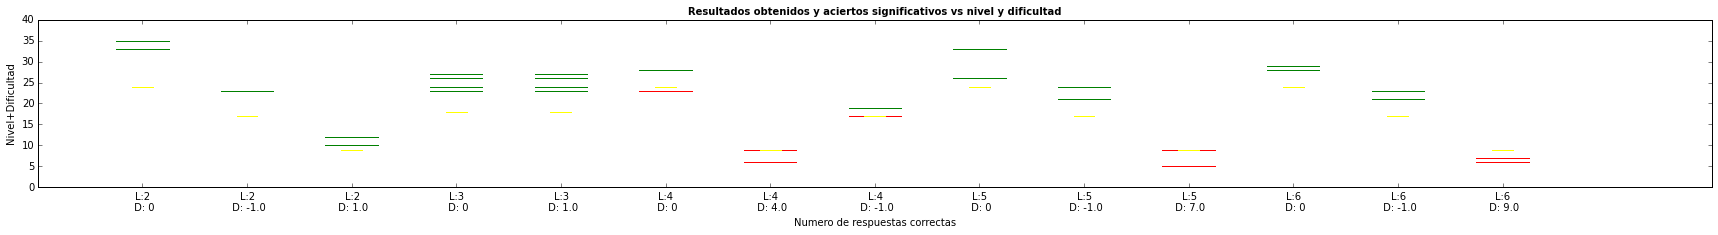

In [127]:
resumen(reporteSignificancia)

In [66]:
reportePandas['strDificultad'] = reportePandas['FiltroDificultad'].apply(str)
reportePandas['strLevel'] = reportePandas['Level'].apply(str)
reportePandas['Tag'] = "L:" + reportePandas['Level'].apply(str) +' D: '  + reportePandas['FiltroDificultad'].apply(str)
reportePandas['Level+Dificultad']

0        L:1 D: 0
1     L:1 D: -1.0
2        L:2 D: 0
3     L:2 D: -1.0
4      L:2 D: 1.0
5        L:3 D: 0
6      L:3 D: 1.0
7        L:1 D: 0
8     L:1 D: -1.0
9        L:2 D: 0
10     L:2 D: 1.0
11    L:2 D: -1.0
12       L:3 D: 0
13     L:3 D: 1.0
14       L:3 D: 0
15     L:3 D: 1.0
16       L:4 D: 0
17     L:4 D: 4.0
18    L:4 D: -1.0
19       L:5 D: 0
20    L:5 D: -1.0
21     L:5 D: 7.0
22       L:6 D: 0
23    L:6 D: -1.0
24     L:6 D: 9.0
25       L:1 D: 0
26    L:1 D: -1.0
27       L:1 D: 0
28    L:1 D: -1.0
29       L:2 D: 0
30    L:2 D: -1.0
31     L:2 D: 1.0
32       L:3 D: 0
33     L:3 D: 1.0
34       L:4 D: 0
35    L:4 D: -1.0
36     L:4 D: 4.0
37       L:5 D: 0
38     L:5 D: 7.0
39    L:5 D: -1.0
40       L:6 D: 0
41    L:6 D: -1.0
42     L:6 D: 9.0
43       L:1 D: 0
44    L:1 D: -1.0
Name: Level+Dificultad, dtype: object